In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 12)
pd.set_option('display.max_colwidth', 200)

# Utilities

In [9]:
def eval_w(x):
    try:
        return eval(x)
    except Exception as e:
        print(x, e)
        return []

def check_list_lengths(series):
    return series.apply(lambda x: len(x)).value_counts()
        
def np_from_str(string):
    string = string.replace("[]","").replace("]","").replace("[","").replace(".","")
    float_list = [float(i.strip()) for i in string.split()]
    return float_list

# Main

In [78]:
inputfile = "../data/TactSim-Draft1.csv"
inputfile = "../data/TactSim-Draft2.pkl"

In [79]:
sim_df = pd.read_pickle(inputfile)
print(sim_df.shape)
sim_df[:3]

(12499, 7)


,FiringRate,Spikes,Frequency,depth,Afferent_Class,duration,Pin_Radius
0,[95.30292716133424],"[0.001, 0.0098, 0.02, 0.0304, 0.040799999999999996, 0.0514, 0.0618, 0.0724, 0.08280000000000001, 0.09340000000000001, 0.10400000000000001, 0.1144, 0.125, 0.1354, 0.14600000000000002, 0.15660000000...",95,1.60,PC,1.763,1.07
1,[130.586186883343],"[0.001, 0.0063999999999999994, 0.013000000000000001, 0.0206, 0.027999999999999997, 0.0358, 0.043199999999999995, 0.051, 0.0584, 0.0664, 0.0738, 0.08180000000000001, 0.0892, 0.09720000000000001, 0....",65,0.58,PC,1.034,1.39
2,[0.7628928898382668],[0.0494],95,2.04,RA,1.311,1.38


# Notes

- 21.5k Samples & 7 Columns
- Columns
  - Predictors
      - FiringRate
      - Spikes
      - Afferent_Class
  - Target
      - Frequency

## check data: FiringRate

- Contains list with only one value

In [80]:
check_list_lengths(sim_df["FiringRate"])

1    12499
Name: FiringRate, dtype: int64

In [81]:
sim_df["FiringRate_value"] = sim_df["FiringRate"].apply(lambda x: round(x[0], 4)).astype("float16")

## check data: Spikes

| num of items | num of samples |
| -- | -- |
| 0 |   10914 | 
| 1 |     314 | 
| 2 |      165 | 
| 3 |       102 | 
| 4 |        78 | 
Sum = 11573

In [82]:
# sim_df["Spikes"].apply(lambda x: len(x)).value_counts()[:30] # len of string

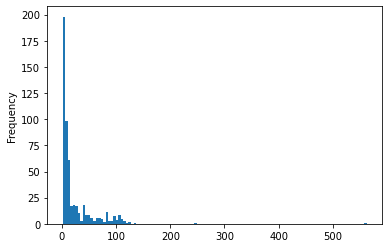

In [83]:
sim_df["Spikes_n_items"] = sim_df["Spikes"].apply(lambda x: len(x))

sim_df["Spikes"].apply(lambda x: len(x)).value_counts()[:].plot(kind="hist", bins=120);

In [84]:
# choosing sample with >10 spike recorded
sim_df["Spikes_n_items"].value_counts().sort_index()
sim_df = sim_df[sim_df["Spikes_n_items"]>10].reset_index(drop=True)

## check data: Afferent_Class

In [85]:
sim_df["Afferent_Class"].value_counts()

PC     6374
RA     4480
SA1       6
Name: Afferent_Class, dtype: int64

In [86]:
sim_df.groupby("Afferent_Class")["Spikes_n_items"].apply(lambda x: x.value_counts()[:5])

Afferent_Class    
PC              47    62
                49    62
                46    62
                39    62
                56    62
RA              36    78
                34    76
                29    72
                39    65
                28    63
SA1             11     3
                12     2
                13     1
Name: Spikes_n_items, dtype: int64

## check data: Frequency

In [87]:
sim_df["Frequency"].value_counts().sort_index()

5      115
15     629
25     924
35    1140
45    1181
55    1279
65    1342
75    1377
85    1463
95    1410
Name: Frequency, dtype: int64

In [88]:
sim_df.groupby("Afferent_Class")["Frequency"].value_counts().sort_index()

Afferent_Class  Frequency
PC              5             10
                15           373
                25           546
                35           716
                45           674
                55           777
                65           797
                75           784
                85           866
                95           831
RA              5            105
                15           256
                25           378
                35           424
                45           507
                55           502
                65           543
                75           592
                85           595
                95           578
SA1             65             2
                75             1
                85             2
                95             1
Name: Frequency, dtype: int64

In [89]:
# sim_df.groupby(["Afferent_Class","Frequency"])["Spikes_n_items"].value_counts().sort_index()

# Visualize Data: spikes

In [90]:
sim_df["Spikes_n_items"].agg(["mean","median"])

mean      109.913352
median     72.000000
Name: Spikes_n_items, dtype: float64

In [91]:
sim_df["Frequency"][:5]

0    95
1    65
2    55
3    65
4    85
Name: Frequency, dtype: int64

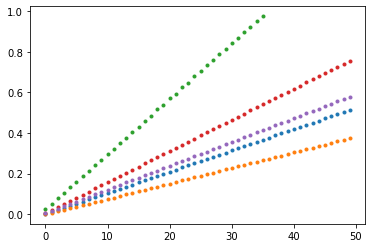

In [92]:
plt.plot(sim_df["Spikes"][0][:50], ".")
plt.plot(sim_df["Spikes"][1][:50], ".")
plt.plot(sim_df["Spikes"][2][:50], ".")
plt.plot(sim_df["Spikes"][3][:50], ".")
plt.plot(sim_df["Spikes"][4][:50], ".")

# Feature Engineering

In [93]:
sim_df_feat = pd.concat([sim_df,pd.get_dummies(sim_df["Afferent_Class"])],1)

In [99]:
def diff_feats(x, period=2):
    tmp_sr = pd.Series(x)
    if len(tmp_sr)>1:
        return np.mean(pd.Series.diff(tmp_sr, period))
    else:
        return -1

sim_df_feat["Spikes_diff_mean_2"] = sim_df_feat["Spikes"].apply(lambda x: diff_feats(x, period=5))
sim_df_feat["Spikes_diff_mean_5"] = sim_df_feat["Spikes"].apply(lambda x: diff_feats(x, period=15))

In [100]:
def diff_time_inrange(x, start=0, end=10):
    if len(x)>end:
        return x[end]-x[start]
    else:
        return -1

sim_df_feat["Spikes_diff_time_inrange"] = sim_df_feat["Spikes"].apply(lambda x: diff_time_inrange(x))

# Feature Explore/Viz

In [104]:
print(sim_df_feat.shape)
sim_df_feat.isna().sum()

(10860, 15)


FiringRate                    0
Spikes                        0
Frequency                     0
depth                         0
Afferent_Class                0
duration                      0
Pin_Radius                    0
FiringRate_value              0
Spikes_n_items                0
PC                            0
RA                            0
SA1                           0
Spikes_diff_mean_2            0
Spikes_diff_mean_5          285
Spikes_diff_time_inrange      0
dtype: int64

In [102]:
corr = sim_df_feat.dropna().corr()
corr.style.background_gradient(cmap='coolwarm')
# corr

/home/minesh_1291/anaconda3/envs/noaa-runtime/lib/python3.8/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/minesh_1291/anaconda3/envs/noaa-runtime/lib/python3.8/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Frequency,depth,duration,Pin_Radius,FiringRate_value,Spikes_n_items,PC,RA,SA1,Spikes_diff_mean_2,Spikes_diff_mean_5,Spikes_diff_time_inrange
Frequency,1.000000,0.188111,-0.006036,-0.001150,0.449326,0.431117,0.010432,-0.010432,nan,-0.465382,-0.465722,-0.457629
depth,0.188111,1.000000,0.000065,0.005213,-0.329279,-0.314501,0.295845,-0.295845,nan,0.227157,0.227400,0.226639
duration,-0.006036,0.000065,1.000000,0.007153,0.015955,0.228804,0.009797,-0.009797,nan,0.039267,0.039257,0.039452
Pin_Radius,-0.001150,0.005213,0.007153,1.000000,0.007302,0.005747,-0.002291,0.002291,nan,-0.005077,-0.004966,-0.003047
FiringRate_value,0.449326,-0.329279,0.015955,0.007302,1.000000,0.960542,0.258037,-0.258037,nan,-0.707840,-0.708685,-0.696078
Spikes_n_items,0.431117,-0.314501,0.228804,0.005747,0.960542,1.000000,0.247994,-0.247994,nan,-0.673552,-0.674330,-0.662343
PC,0.010432,0.295845,0.009797,-0.002291,0.258037,0.247994,1.000000,-1.000000,nan,-0.251669,-0.251680,-0.257793
RA,-0.010432,-0.295845,-0.009797,0.002291,-0.258037,-0.247994,-1.000000,1.000000,nan,0.251669,0.251680,0.257793
SA1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Spikes_diff_mean_2,-0.465382,0.227157,0.039267,-0.005077,-0.707840,-0.673552,-0.251669,0.251669,nan,1.000000,0.999673,0.994630


In [77]:
np.corrcoef(sim_df["Frequency"], sim_df["Spikes_diff_time_inrange"])

array([[ 1.        , -0.39405434],
       [-0.39405434,  1.        ]])

# export data

In [68]:
sim_df[:3]

,FiringRate,Spikes,Frequency,depth,Afferent_Class,duration,Pin_Radius,FiringRate_value,Spikes_n_items,Spikes_diff_time_inrange,Spikes_diff_mean,PC,RA,SA1,PC,RA,SA1,Spikes_diff_mean_2,Spikes_diff_mean_5
0,[95.30292716133424],"[0.001, 0.0098, 0.02, 0.0304, 0.040799999999999996, 0.0514, 0.0618, 0.0724, 0.08280000000000001, 0.09340000000000001, 0.10400000000000001, 0.1144, 0.125, 0.1354, 0.14600000000000002, 0.15660000000...",95,1.60,PC,1.7630,1.070,95.3125,168,0.1030,0.021029,1,0,0,1,0,0,0.021029,0.052596
1,[130.586186883343],"[0.001, 0.0063999999999999994, 0.013000000000000001, 0.0206, 0.027999999999999997, 0.0358, 0.043199999999999995, 0.051, 0.0584, 0.0664, 0.0738, 0.08180000000000001, 0.0892, 0.09720000000000001, 0....",65,0.58,PC,1.0340,1.390,130.6250,135,0.0728,0.015332,1,0,0,1,0,0,0.015332,0.038385
2,[35.24574113961229],"[0.026199999999999998, 0.049999999999999996, 0.07980000000000001, 0.10400000000000001, 0.13440000000000002, 0.1584, 0.189, 0.2132, 0.2434, 0.26739999999999997, 0.298, 0.32199999999999995, 0.352599...",55,1.30,PC,1.0215,0.825,35.2500,36,0.2718,0.054482,1,0,0,1,0,0,0.054482,0.136168


In [71]:
feature_cols = ["PC", "RA", "SA1","FiringRate_value","Spikes_n_items", "Spikes_diff_mean", "depth", "Pin_Radius", "Spikes_diff_time_inrange", 
                "Spikes_diff_mean_2","Spikes_diff_mean_5"]
target_col = "Frequency"

In [72]:
sim_df[feature_cols+[target_col]].to_csv("../data/dataset_v2.csv")